# Cluster Analysis

Households are to be clustered based on either hourly or daily consumption profiles.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
import elec_consumption.performance as performance
import elec_consumption.cluster as cluster 
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from tslearn.clustering import KShape, TimeSeriesKMeans
from tslearn.utils import (
    check_equal_size, to_time_series_dataset, to_sklearn_dataset
)

/Users/edxu96/Library/Caches/pypoetry/virtualenvs/elec-consumption-FzRBkitR-py3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/edxu96/Library/Caches/pypoetry/virtualenvs/elec-consumption-FzRBkitR-py3.7/lib/python3.7/site-packages/tslearn/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [6 * 1.61803398875, 6]
_seed = 123  # for clustering analysis
mts = {}  # different multivariate time series

## Introduction

There are at least two challenges in this task:

1. Many NaN slots and distributed differently.
2. All series are non-stationary because of non-business-days.

Import dataframe and test.

In [ ]:
#hide
df = pd.read_csv('./data/raw.csv', index_col=0)
df.columns = list(range(df.shape[1]))
df.columns.name = 'household'
df.index = pd.to_datetime(df.index)
df.index.name = 'datetime'

In [ ]:
#hide
mts['fill0'] = to_time_series_dataset(df.fillna(0).T)
n_ts, max_sz, d = mts['fill0'].shape

In [ ]:
assert (n_ts == 500 and max_sz == 5856 and d == 1)
assert check_equal_size(mts['fill0'])

In [ ]:
#hide
mts['smallTimeSeries'] = to_time_series_dataset(df.iloc[:, :50].T)
mts['small'] = to_sklearn_dataset(mts['smallTimeSeries'])

## 1. Four Cluster using k-Means 
For example, assume there are 4 clusters.

In [ ]:
#hide
n_clusters = 6
km = TimeSeriesKMeans(
    n_clusters=n_clusters, verbose=False, random_state=_seed)
clustered = km.fit_predict(mts['fill0'])

description = df.describe().T
description['cluster_id'] = clustered

In [ ]:
#hide_input
description.head(3)

,count,mean,std,min,25%,50%,75%,max,cluster_id
household,,,,,,,,,
0,5328.0,0.122169,0.135841,0.011,0.052,0.082,0.137,1.540,1
1,5280.0,0.128278,0.154372,0.010,0.043,0.075,0.144,1.479,1
2,5328.0,0.147232,0.093699,0.026,0.086,0.126,0.180,1.131,1


## 2. Performance Evaluation

In [ ]:
#hide
mts['fill0sk'] = to_sklearn_dataset(mts['fill0'])

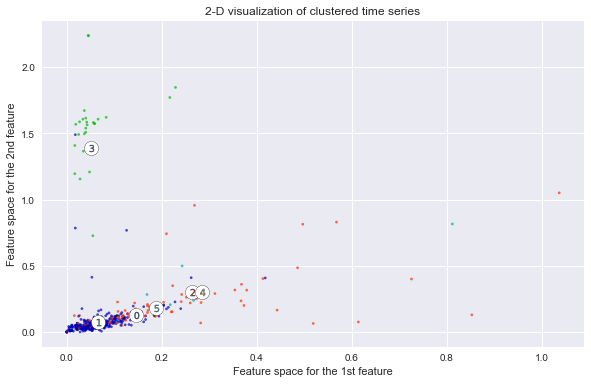

In [ ]:
#hide_input
performance.plot_silhouette_2d(
    n_clusters, clustered, mts['fill0sk'], centers=km.cluster_centers_
)

For n_clusters = 6,  the average silhouette_score is : 0.2857721756153429.


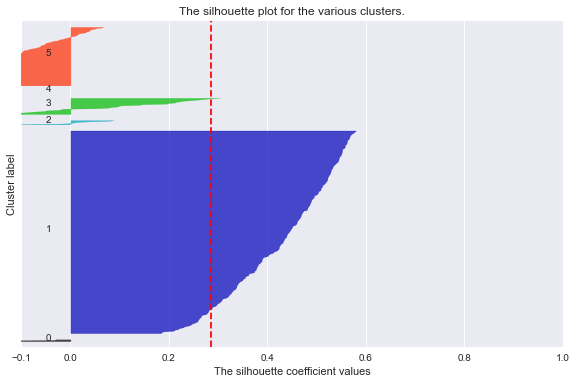

In [ ]:
#hide_input
performance.plot_silhouette(
    n_clusters, clustered, mts['fill0sk']
)

## 3. Without NBDs

When non-business-days (NBDs) are excluded:

In [ ]:
#hide
mts['fillZeroNbd'] = to_time_series_dataset(
    df[df.index.dayofweek < 5].fillna(0).T
)
n_ts, max_sz, d = mts['fillZeroNbd'].shape

In [ ]:
assert (n_ts == 500 and max_sz == 4224 and d == 1)
assert check_equal_size(mts['fillZeroNbd'])

In [ ]:
#hide
n_clusters = 3
km = TimeSeriesKMeans(
    n_clusters=n_clusters, verbose=False, random_state=_seed)
clustered = km.fit_predict(mts['fillZeroNbd'])

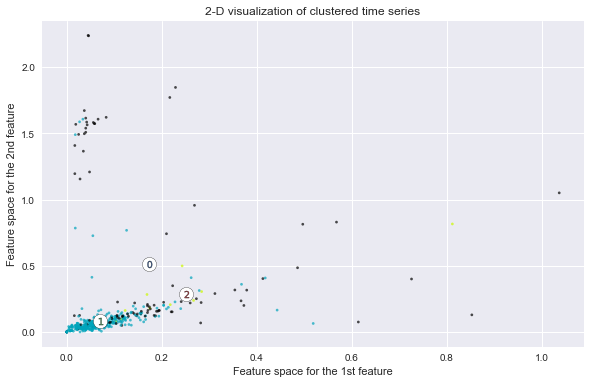

In [ ]:
#hide_input
mts['fillZeroNbdSk'] = to_sklearn_dataset(mts['fillZeroNbd'])
performance.plot_silhouette_2d(
    n_clusters, clustered, mts['fillZeroNbdSk'], centers=km.cluster_centers_
)

## 4. Agglomerative Hierarchical (Single Linkage)

`AgglomerativeClustering` in `sklearn` doesn't work if there is NaN in original data set, though it doesn't matter if single linkage is used.

In [ ]:
#hide
tree = cluster.mst_corr(df.iloc[:, :150])
pos = nx.spring_layout(tree)

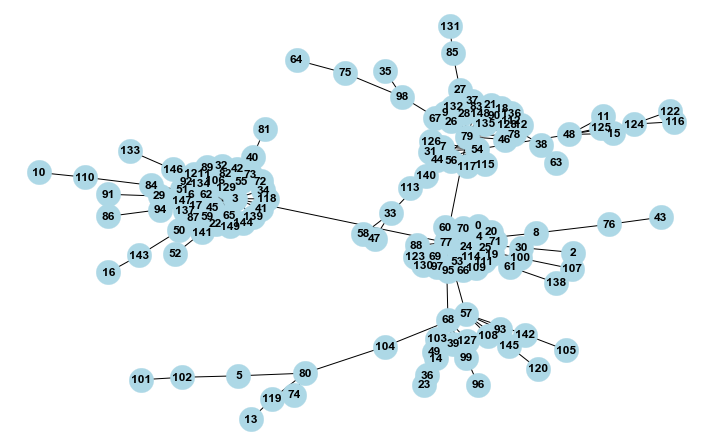

In [ ]:
#hide_input
cluster.draw_graph(tree, pos)

It can be seen that there are three nodes with high degrees: 3, 77, and 79. So then can be seen as cluster centres.

In [ ]:
#hide_input
cluster.gather_nodes_info(tree).head(5)

,degree
3,38
77,28
79,21
54,9
68,7


In [ ]:
#hide
g = cluster.keep_cluster(tree, 3)

Edge from 140  to 113 with weight 0.12374774528838905 is removed.
Edge from 14  to 23 with weight 0.12394414737122872 is removed.
Edge from 77  to 114 with weight 0.12412971416970729 is removed.


## 5. Use `KShape`

It takes a while to cluster using `KShape`.

In [ ]:
#hide
# ks = KShape(3, verbose=False)
# clustered_ks = ks.fit_predict(mts)
# description['cluster_id_ks'] = clustered_ks

## 6. Optimal Num of Clusters

In [ ]:
#hide
def cal_inertia(n_clusters: int) -> float:
    """Calculate sum of distances to closest cluster centre.
    
    Args:
        n_clusters: number of clusters.
    
    Returns:
        Sum of distances to closest cluster centre.
    """
    km = TimeSeriesKMeans(
        n_clusters=n_clusters, verbose=False, random_state=_seed)
    km.fit_predict(mts['fill0'])
    return km.inertia_

In [ ]:
#hide
y = []
x = [i for i in range(1, 3)]
for n_clusters in x:
    y.append(cal_inertia(n_clusters))

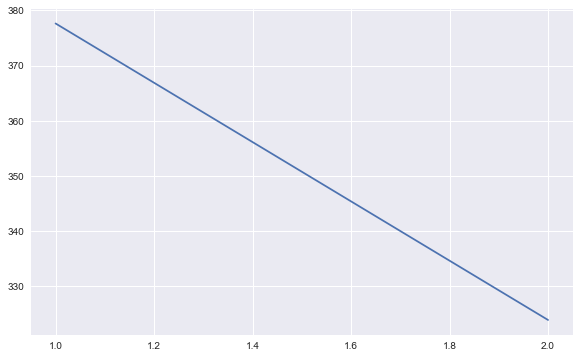

In [ ]:
#hide_input
sns.lineplot(x=x, y=y);